# Guide to phenomd waveform creation and snr calculation

This guide shows how to create waveforms with the ``PhenomDWaveforms`` and ``EccentricBinaries`` classes from ``gwsnrcalc.utils.waveforms``; perform snr calculations with ``snr`` from ``gwsnrcalc.gw_snr_calculator``; and read noise curves with ``read_noise_curve`` from ``gwsnrcalc.utils.readnoisecurves``. The snr calculator has the option of generating large amounts of snrs in parallel across many sensitivity curves if desired.

These modules are part of the ``gwsnrcalc`` package. This package also includes the grid generation modules used in BOWIE. These are not detailed here. They are detailed in the notebooks at https://github.com/mikekatz04/BOWIE/tree/master/notebooks. 

For general documentation related to ``gwsnrcalc``, see https://mikekatz04.github.io/BOWIE/gwsnrcalc.html.

For usage of these codes, please cite the paper for BOWIE, (arXiv:1807.02511). This code is shared under the GNU Public License. 

If you use PhenomDWaveforms, please cite Husa et al 2016 (arXiv:1508.07250), Khan et al 2016 (arXiv:1508.07253).

In [1]:
import os
os.chdir('/Users/michaelkatz/Documents/Research/PythonCodes/BOWIE_analysis/snr_calculator_folder/')
from gwsnrcalc.utils.waveforms import PhenomDWaveforms
from gwsnrcalc.utils.waveforms import EccentricBinaries
from gwsnrcalc.gw_snr_calculator import snr
from gwsnrcalc.utils.readnoisecurves import read_noise_curve, show_available_noise_curves
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy import interpolate
%matplotlib inline

## PhenomDWaveforms

PhenomDWaveforms takes binary parameter inputs of either scalar value or 1D arrays. It outputs frequency domain waveforms produced by phenomD (See Husa et al 2016 (arXiv:1508.07250) and Khan et al 2016 (arXiv:1508.07253)). In its current state, it returns the characteristic strain and not the phase. Its returns are frequencies and characteristic strain amplitudes, as well as the merger frequency and peak frequency. The merger frequency separates the inspiral phase from the merger phase, and the peak frequency separates merger from ringdown (see paper describing BOWIE for details, arXiv: arXiv:1807.02511) and the phenomd papers for more information.

What follows is a few examples using this class. For direct access to PhenomDWaveforms documentation, see https://mikekatz04.github.io/BOWIE/gwsnrcalc.html#module-gwsnrcalc.utils.pyphenomd.

### Array Input on all Parameters

Frequencies -> [[1.24929558e-02 1.24933526e-02 1.24937493e-02 ... 1.62033821e-02
  1.62038966e-02 1.62044112e-02]
 [3.28623112e-04 3.28888755e-04 3.29154614e-04 ... 2.45694071e-01
  2.45892679e-01 2.46091447e-01]
 [6.74192289e-07 6.74414715e-07 6.74637214e-07 ... 1.00441360e-05
  1.00474497e-05 1.00507645e-05]] 

Characteristic Strain hc -> [[5.32736274e-21 5.32733444e-21 5.32730613e-21 ... 5.10044737e-21
  5.10042025e-21 5.10039313e-21]
 [6.45853116e-19 6.45762864e-19 6.45672622e-19 ... 5.66131204e-24
  5.59767411e-24 5.53472122e-24]
 [1.06376528e-16 1.06291469e-16 1.06206443e-16 ... 2.05295966e-21
  2.04621827e-21 2.03949758e-21]] 

Merger Frequencies -> [3.63402867e+01 2.66495436e-02 1.08840958e-06] 

Peak Frequencies -> [1.02612958e+02 8.69314997e-02 2.10876065e-06] 



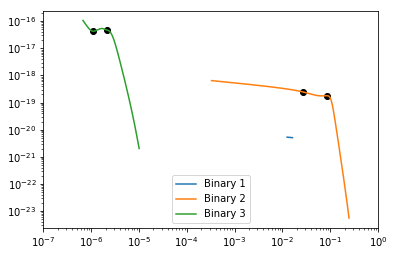

In [4]:
# initialize waveform generator
phenomdwave = PhenomDWaveforms()

#masses
m1 =np.array([1e1, 1e5, 1e9])
m2 = np.array([1e2, 1e4, 1e7])

#spins
chi1 = np.array([0.3, 0.5, -0.8])
chi2 = np.array([0.2, 0.99, -0.9])

#redshift
z = np.array([0.1, 0.5, 3.0])

#start times
st = np.array([10.0, 1.0, 8.0])

#end times
et = np.array([5.0, 0.0, 0.0])

## Produce Waveforms ##
wave = phenomdwave(m1, m2, chi1, chi2, z, st, et)

## Print Waveforms ##
print('Frequencies ->', wave.freqs, '\n')
print('Characteristic Strain hc ->', wave.hc, '\n')
print('Merger Frequencies ->', wave.fmrg, '\n')
print('Peak Frequencies ->', wave.fpeak, '\n')

for i in range(len(wave.freqs)):
    plt.loglog(wave.freqs[i], wave.hc[i], label=r'Binary %i'%(i+1))
    for f in [wave.fmrg[i], wave.fpeak[i]]:
        if np.searchsorted(wave.freqs[i], f) < len(wave.freqs[i]):
            plt.scatter(f, wave.hc[i][np.searchsorted(wave.freqs[i], f)], color='k')
plt.xlim(1e-7, 1e0)
plt.legend(loc = 'lower center')

### Scalar input for start and end Times, as well as luminosity distance as input rather than redshift. 

Frequencies -> [[1.32407967e-02 1.32573493e-02 1.32739226e-02 ... 3.67387264e+02
  3.67846543e+02 3.68306397e+02]
 [1.58691171e-04 1.58837925e-04 1.58984814e-04 ... 3.07565497e-01
  3.07849926e-01 3.08134618e-01]
 [3.47136584e-07 3.47238382e-07 3.47340209e-07 ... 3.83063344e-06
  3.83175677e-06 3.83288043e-06]] 

Characteristic Strain hc -> [[2.32079623e-19 2.32031118e-19 2.31982623e-19 ... 1.26419911e-24
  1.24493701e-24 1.22595389e-24]
 [1.77230206e-18 1.77202345e-18 1.77174488e-18 ... 1.32379996e-23
  1.30679275e-23 1.28999479e-23]
 [3.53864001e-17 3.53668679e-17 3.53473683e-17 ... 1.40076141e-21
  1.39667191e-21 1.39259357e-21]] 

Merger Frequencies -> [3.98843499e+01 3.33682744e-02 4.15067307e-07] 

Peak Frequencies -> [1.12620221e+02 1.08848173e-01 8.04180359e-07] 



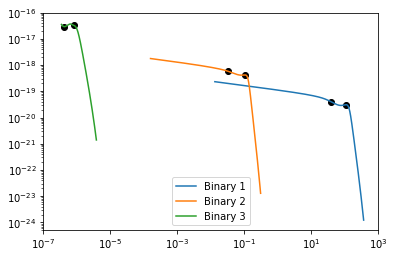

In [5]:
# change generator for luminosity distance
phenomdwave = PhenomDWaveforms(dist_type='luminosity_distance')

#start times
st = 10.0

#end times
et = 0.0

#luminosity distance (Mpc)
lum_dis = np.array([1e1, 1e3, 1e5])

## Produce Waveforms ##
wave = phenomdwave(m1, m2, chi1, chi2, lum_dis, st, et)



## Print Waveforms ##
print('Frequencies ->', wave.freqs, '\n')
print('Characteristic Strain hc ->', wave.hc, '\n')
print('Merger Frequencies ->', wave.fmrg, '\n')
print('Peak Frequencies ->', wave.fpeak, '\n')
for i in range(len(wave.freqs)):
    plt.loglog(wave.freqs[i], wave.hc[i], label=r'Binary %i'%(i+1))
    for f in [wave.fmrg[i], wave.fpeak[i]]:
        if np.searchsorted(wave.freqs[i], f) < len(wave.freqs[i]):
            plt.scatter(f, wave.hc[i][np.searchsorted(wave.freqs[i], f)], color='k')
plt.xlim(1e-7, 1e3)
plt.legend(loc = 'lower center')

### All scalar inputs and comoving distance as distance measure. Also, change number of frequency points.  

Frequencies -> [3.10285378e-03 3.10462732e-03 3.10640187e-03 ... 3.60525927e+01
 3.60731997e+01 3.60938185e+01] 

Characteristic Strain hc -> [2.00114629e-19 2.00095455e-19 2.00076283e-19 ... 9.83896063e-25
 9.72772630e-25 9.61771894e-25] 

Merger Frequencies -> 3.9086437296484253 

Peak Frequencies -> 18.232489121529646 



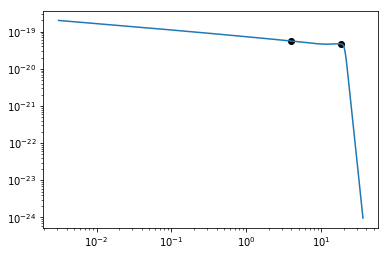

In [6]:
# change dist_type and num_points
phenomdwave = PhenomDWaveforms(dist_type='comoving_distance', num_points=int(2**14))

m1, m2, chi1, chi2, com_dist, st, et = 1e2,1e3,0.99,0.9, 1e2, 10.0, 0.0

wave = phenomdwave(m1, m2, chi1, chi2, com_dist, st, et)

## Print Waveforms ##
print('Frequencies ->', wave.freqs, '\n')
print('Characteristic Strain hc ->', wave.hc, '\n')
print('Merger Frequencies ->', wave.fmrg, '\n')
print('Peak Frequencies ->', wave.fpeak, '\n')

plt.loglog(wave.freqs, wave.hc)
for f in [wave.fmrg, wave.fpeak]:
    if np.searchsorted(wave.freqs, f) < len(wave.freqs):
        plt.scatter(f, wave.hc[np.searchsorted(wave.freqs, f)], color='k')


# Eccentric Waveforms

For eccentric binaries, an eccentric waveform generator is available for inspiral calculations. It is called in much the same way as phenomd waveforms above. When calculating SNRs, the kwarg `ecc=True` must be supplied to the `snr` function. When using `gwsnrcalc.generate_contour_data`, the generator will figure out if the desired waveform is eccentric based on the input information. The waveform calculator is based on **FIND**.

The kwargs necessary for waveform creator instantiantion are `dist_type`, `num_points`, `initial_cond_type`, and `n_max`. `dist_type` and `num_points` are the same as with PhenomDWaveforms. However, `num_points` is now the number of points for each mode. `initial_cond_type` indicates what is the initial quantity provided. It can be a time before merger (`initial_cond_type = time`), an initial frequency (`initial_cond_type = frequency`), or an initial separation (`initial_cond_type = separation`). `n_max` indicates the maximum number of modes to examine.

### Array of inputs.

One massive black hole binary and one stellar mass at varying eccentricities and times before merger.

Text(0.5,0,'Frequency (Hz)')

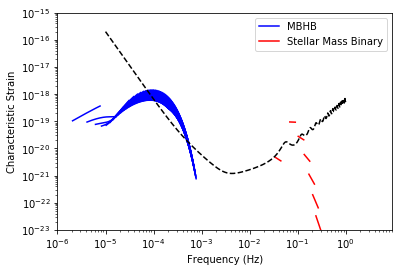

In [47]:
n_max = 100
ecc_bin_wave = EccentricBinaries(dist_type='redshift', num_points=1024, initial_cond_type='time', n_max=n_max)

m1 = np.array([1e6, 4e1])
m2 = np.array([4e6, 3.5e1])
z_or_dist = np.array([1.5, 0.01])
initial_point = np.array([8.0, 10.0])  # years before merger
e0 = np.array([0.9, 0.1])
t_obs = 5.0

waves = ecc_bin_wave(m1, m2, z_or_dist, initial_point, e0, t_obs)

colors = ['blue', 'red']
labels = ['MBHB', 'Stellar Mass Binary']
for i in range(len(m1)):
    for j in range(n_max):
        if j == 0:
            label = labels[i]
        else:
            label = None
        plt.loglog(waves.freqs[i][j], waves.hc[i][j], color=colors[i], label=label)
        
f, hn = read_noise_curve('LPA', noise_type_out='char_strain')
plt.loglog(f, hn, color='k', ls='--')


plt.ylim(1e-23, 1e-15)
plt.legend(loc='best')
plt.ylabel('Characteristic Strain')
plt.xlabel('Frequency (Hz)')

Now do the same with luminosity distance as the distance measure and the frequency as the starting point.

Text(0.5,0,'Frequency (Hz)')

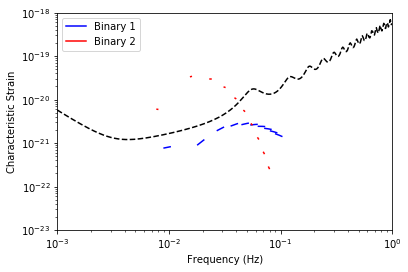

In [12]:
n_max = 10
ecc_bin_wave = EccentricBinaries(dist_type='luminosity_distance', num_points=1024, initial_cond_type='frequency', n_max=n_max)

m1 = np.array([4e1, 4e1])
m2 = np.array([3e1, 3.5e1])
z_or_dist = np.array([500.0, 100.0])  # luminosity distance in Mpc
initial_point = np.array([1e-2, 8e-3])  # years before merger
e0 = np.array([0.6, 0.3])
t_obs = 10.0

waves = ecc_bin_wave(m1, m2, z_or_dist, initial_point, e0, t_obs)

colors = ['blue', 'red']
labels = ['Binary 1', 'Binary 2']
for i in range(len(m1)):
    for j in range(n_max):
        if j == 0:
            label = labels[i]
        else:
            label = None
        plt.loglog(waves.freqs[i][j], waves.hc[i][j], color=colors[i], label=label)
        
f, hn = read_noise_curve('LPA', noise_type_out='char_strain')
plt.loglog(f, hn, color='k', ls='--')


plt.ylim(1e-23, 1e-18)
plt.xlim(1e-3,1e0)
plt.legend(loc='best')
plt.ylabel('Characteristic Strain')
plt.xlabel('Frequency (Hz)')

# snr function

The snr function is provided as a handy way to combine PhenomDWaveforms and csnr functions. The input is binary parameters and keyword arguments related to the sensitivity curves, snr calculation, and parallel generation of the process. For documentation on this function see https://mikekatz04.github.io/BOWIE/gwsnrcalc.html#module-gwsnrcalc.gw_snr_calculator. **Note**: there is a class with the name ``gwsnrcalc.gw_snr_calculator.SNR``. This is different than ``gwsnrcalc.gw_snr_calculator.snr``, which is a function. The function uses the class to run its operation.

In [7]:
#masses
m1 =np.array([1e1, 1e5, 1e8])
m2 = np.array([1e2, 1e4, 1e7])

#spins
chi1 = np.array([0.3, 0.5, -0.8])
chi2 = np.array([0.2, 0.99, -0.9])

#redshift
z = np.array([0.1, 0.5, 3.0])

#start times
st = np.array([10.0, 1.0, 8.0])

#end times
et = np.array([5.0, 0.0, 0.0])

snr_out = snr(m1, m2, chi1, chi2, z, st, et,
              add_wd_noise='Both', signal_type= ['all', 'ins', 'mrg', 'rd'],
              sensitivity_curves='LPA', prefactor=1)

for key in ['all', 'ins', 'mrg', 'rd']:
    print('With WD noise:', key, snr_out['LPA_wd_' + key], '\n')
    print('Without WD noise:', key, snr_out['LPA_' + key], '\n')

With WD noise: all [  1.29078513 396.22611864   1.03040305] 

Without WD noise: all [  1.29078513 419.58974495   1.03040305] 

With WD noise: ins [1.29078513e+00 3.94826925e+02 1.25535081e-46] 

Without WD noise: ins [1.29078513e+00 4.18268715e+02 1.25535081e-46] 

With WD noise: mrg [ 0.         32.96355335  0.52041204] 

Without WD noise: mrg [ 0.         32.96355335  0.52041204] 

With WD noise: rd [0.         4.49892924 0.88932657] 

Without WD noise: rd [0.         4.49892924 0.88932657] 



In [9]:
#masses
m1 =np.array([1e1, 1e5, 1e9])
m2 = np.array([1e2, 1e4, 1e7])

#spins
chi1 = np.array([0.3, 0.5, -0.8])
chi2 = np.array([0.2, 0.99, -0.9])

#redshift
z = np.array([0.1, 0.5, 3.0])

#start times
st = np.array([10.0, 1.0, 8.0])

#end times
et = np.array([5.0, 0.0, 0.0])

out = snr(m1, m2, chi1, chi2, z, 
    st, et, sensitivity_curve='PL', 
    add_wd_noise=False, phase='all', prefactor=1.0, 
    dist_type='redshift', num_points=8192)

print(out)

{'LPA_all': array([1.29078513e+00, 4.19589745e+02, 7.57851636e-07])}


### Eccentric Binary SNR

In [53]:
n_max = 100
ecc_bin_wave = EccentricBinaries(dist_type='redshift', num_points=1024, initial_cond_type='time', n_max=n_max)

m1 = np.array([1e6, 4e1])
m2 = np.array([4e6, 3.5e1])
z_or_dist = np.array([1.5, 0.01])
initial_point = np.array([8.0, 10.0])  # years before merger
e0 = np.array([0.9, 0.1])
t_obs = 5.0

snr_out = snr(m1, m2, z_or_dist, initial_point, e0, t_obs,
              add_wd_noise='Both', signal_type= ['all', 'modes'],
              sensitivity_curves='LPA', prefactor=1,
              ecc=True)  # this line is important

key = 'all'
print('With WD noise:', key, snr_out['LPA_wd_' + key], '\n')
print('Without WD noise:', key, snr_out['LPA_' + key], '\n')

key = 'modes'
print('With WD noise:', key, snr_out['LPA_wd_' + key], '\n')
print('Without WD noise:', key, snr_out['LPA_' + key], '\n')

With WD noise: all [1.52496462e-47 2.47662709e-49] 

Without WD noise: all [1.52496462e-47 2.47662709e-49] 

With WD noise: modes [[1.24647756e-049 1.52086264e-047 5.14906809e-049 3.87158017e-049
  3.22137066e-049 2.80110832e-049 2.49957984e-049 2.26948240e-049
  2.08645614e-049 1.93640257e-049 1.81048844e-049 1.70285040e-049
  1.60942112e-049 1.52727917e-049 1.45426605e-049 1.38874925e-049
  1.32946952e-049 1.27543910e-049 1.22587186e-049 1.18013419e-049
  1.13770971e-049 1.09817339e-049 1.06117230e-049 1.02641104e-049
  9.93640546e-050 9.62649481e-050 9.33257394e-050 9.05309358e-050
  8.78671661e-050 8.53228337e-050 8.28878350e-050 8.05533287e-050
  7.83115462e-050 7.61556344e-050 7.40795248e-050 7.20778240e-050
  7.01457214e-050 6.82789119e-050 6.64735291e-050 6.47260898e-050
  6.30334455e-050 6.13927416e-050 5.98013816e-050 5.82569966e-050
  5.67574191e-050 5.53006598e-050 5.38848878e-050 5.25084129e-050
  5.11696708e-050 4.98672094e-050 4.85996775e-050 4.73658143e-050
  4.61644402

# Read noise curves

read_noise_curves.py provides an easy way to interface with the noise curves provided with the package. They are detailed in our paper mentioned above. You can choose the output type of the curve and if you want to add white dwarf noise. For further documentation, see https://mikekatz04.github.io/BOWIE/gwsnrcalc.html#module-gwsnrcalc.utils.readnoisecurves.

### Check which sensitivity curves are available.

In [10]:
show_available_noise_curves()

['PL', 'HB_wd_noise', 'CL', 'CLLF', 'PLCS', 'LPA', 'PLHB']

### Read a few of them

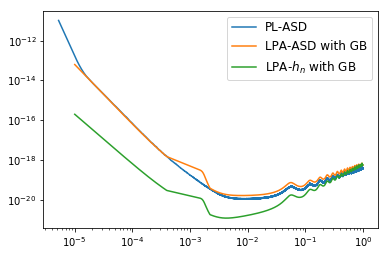

In [11]:
fn, amp = read_noise_curve('PL', add_wd_noise=False, noise_type_out='ASD')
plt.loglog(fn, amp, label='PL-ASD')

fn, amp = read_noise_curve('LPA', add_wd_noise=True, noise_type_out='ASD')
plt.loglog(fn, amp, label='LPA-ASD with GB')

fn, amp = read_noise_curve('LPA', add_wd_noise=True, noise_type_out='char_strain')
plt.loglog(fn, amp, label=r'LPA-$h_n$ with GB')

plt.legend(prop={'size':12})

### Read from a file

To read from a file, the file must be .txt or .csv. The column with frequency values must have the label 'f'. The amplitude column must have a label equivalent to its type (i.e. 'ASD', 'PSD, or 'char_strain'). 

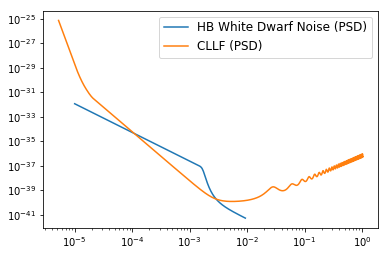

In [12]:
# you may need to edit the file path. This is an example.
file_path = 'gwsnrcalc/utils/noise_curves/HB_wd_noise.txt'
fn, amp = read_noise_curve(file_path, noise_type_in='ASD', noise_type_out='PSD')
plt.loglog(fn, amp, label='HB White Dwarf Noise (PSD)')

file_path = 'gwsnrcalc/utils/noise_curves/CLLF.txt'
fn, amp = read_noise_curve(file_path, noise_type_in='ASD', noise_type_out='PSD')
plt.loglog(fn, amp, label='CLLF (PSD)')
plt.legend(prop={'size':12})